In [1]:
import os
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
# import nltk
# nltk.set_proxy('http://127.0.0.1:7890')
# nltk.download('punkt') # [nltk_data] Downloading package punkt to /home/tyd/nltk_data...
from nltk.tokenize import word_tokenize

class Defects4JDataset(Dataset):
    def __init__(self, defects4j_dir, model_name, test_size=0.2, random_state=None):
        self.project_ids = ['Chart', 'Cli', 'Closure', 'Codec', 'Collections', 'Compress', 'Csv', 'Gson', 'JacksonCore',
               'JacksonDatabind', 'JacksonXml', 'Jsoup', 'JxPath', 'Lang', 'Math', 'Mockito', 'Time']
        self.defects4j_dir = defects4j_dir
        self.model_name = model_name
        # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # What a fucking rich programmer dare do this! 
        # Please load the dataset onto the CPU
        # RTX 3080Ti OutOfMemoryError: CUDA out of memory.
        self.model = AutoModel.from_pretrained(model_name)#.to(device)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.test_size = test_size
        self.random_state = random_state
        self.df = pd.DataFrame()
        self.train_df, self.test_df = self.load_data()
        self.train_tokens = self.to_tokens(self.train_df)
        self.test_tokens = self.to_tokens(self.test_df)
        self.train_encodings = self.encoding(self.train_tokens)
        self.test_encodings = self.encoding(self.test_tokens)
        self.train_dataset = self.create_dataset(self.train_encodings, self.train_df)
        self.test_dataset = self.create_dataset(self.test_encodings, self.test_df)

        
    def load_data(self):
        csv_folder = f'{self.defects4j_dir}/csv/'
        for pid in self.project_ids:
            df_t = pd.read_csv(f'{csv_folder}/{pid}/{pid}-modified_classes.csv')
            modified_classes = df_t['Modified Classes'].tolist()
            tokens = [x.split('.')[-1] for x in modified_classes]
            df_dw = pd.read_csv(f'{csv_folder}/{pid}/{pid}-detailed-warnings.csv')
            df_dw['nl_input'] = df_dw['Warning'] + " " + df_dw['Warning Detail']
            df_dw['Label'] = df_dw['Warning'].str.contains('|'.join(tokens)).astype(int)
            self.df = pd.concat([self.df, df_dw], ignore_index=True)
        df_unique = self.df.drop_duplicates(subset=['nl_input', 'Source Code', 'Label'])
        df_unique = df_unique.rename(columns={'Source Code': 'pl_input', 'Label': 'label'})
        train_df, test_df = train_test_split(df_unique, test_size=self.test_size, random_state=self.random_state)
        return train_df, test_df
    
    def to_tokens(self, df):
        nl_tokens = [word_tokenize(x) for x in list(df['nl_input'])]
        df['pl_input'].fillna('[UNK]', inplace=True)
        pl_tokens = [self.tokenizer.tokenize(x, padding=True, truncation=True) for x in list(df['pl_input'])]
        tokens = [[self.tokenizer.cls_token] + nl_tokens[i] + [self.tokenizer.sep_token] + pl_tokens[i] + [self.tokenizer.eos_token] for i in range(len(nl_tokens))]
        return tokens
    
    def encoding(self, tokens):
        tokens_ids = [self.tokenizer.convert_tokens_to_ids(token) for token in tokens]
        context_embeddings = []
        max_seq_length = 150
        tokens_ids = [token[:max_seq_length] + [self.tokenizer.pad_token_id] * (max_seq_length - len(token[:max_seq_length])) for token in tokens_ids] 
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = self.model.to(device)
        with torch.no_grad():
            for tokens_id in tokens_ids:
                tokens_tensor = torch.tensor(tokens_id)[None,:].to(model.device)
                context_embedding = self.model(tokens_tensor)[0].to('cpu')
                context_embeddings.append(context_embedding)
                torch.cuda.empty_cache()
        attention_mask = [[int(token_id != self.tokenizer.pad_token_id) for token_id in tokens] for tokens in tokens_ids]
        return {'input_ids': tokens_ids, 'attention_mask': attention_mask, 'context_embeddings': context_embeddings}
    
    def create_dataset(self, encodings, df):
        class CustomDataset(Dataset):
            def __init__(self, encodings, labels):
                self.encodings = encodings
                self.labels = labels

            def __getitem__(self, idx):
                item = {key: val[idx].detach().clone() if isinstance(val[idx], torch.Tensor) else torch.tensor(val[idx]) for key, val in self.encodings.items()}
                item['label'] = torch.tensor(self.labels[idx])
                return item

            def __len__(self):
                return len(self.labels)

        dataset = CustomDataset(encodings, df['label'].tolist())
        return dataset   
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        row = self.df.iloc[index]
        nl_input = row['nl_input']
        code_line = row['Source Code']
        label = row['Label']
        sample = {'warning': nl_input, 'code': code_line, 'label': label }
        return sample

model_name = "microsoft/codebert-base"
defects4j_dir = os.path.expanduser('~/defects4j')
dataset = Defects4JDataset(defects4j_dir, model_name)
print(len(dataset), dataset[123])

152518 {'warning': 'org.jfree.chart.title.CompositeTitle defines equals but not hashCode Bug type HE_EQUALS_NO_HASHCODE (click for details)\nIn class org.jfree.chart.title.CompositeTitleIn method org.jfree.chart.title.CompositeTitle.equals(Object)At CompositeTitle.java:[lines 207-220]', 'code': 'if (obj == this) {\nreturn true;\n}\nif (!(obj instanceof CompositeTitle)) {\nreturn false;\n}\nCompositeTitle that = (CompositeTitle) obj;\nif (!this.container.equals(that.container)) {\nreturn false;\n}\nif (!PaintUtilities.equal(this.backgroundPaint, that.backgroundPaint)) {\nreturn false;\n}', 'label': 0}


In [2]:
import time

class Timer:
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

In [3]:
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline

def use_svg_display():
    """Use the svg format to display a plot in Jupyter."""
    backend_inline.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    """Set the figure size for matplotlib."""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """Plot data points."""
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else plt.gca()

    # Return True if `X` (tensor or list) has 1 axis
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

In [4]:
class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        """Defined in :numref:`sec_softmax_scratch`"""
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx] 

In [5]:
argmax = lambda x, *args, **kwargs: x.argmax(*args, **kwargs)
astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)
reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)
size = lambda x, *args, **kwargs: x.numel(*args, **kwargs)
def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = argmax(y_hat, axis=1)
    cmp = astype(y_hat, y.dtype) == y
    return float(reduce_sum(astype(cmp, y.dtype)))


def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # Required for BERT Fine-tuning (to be covered later)
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), size(y))
    return metric[0] / metric[1]

In [6]:
def collate_fn(batch):
    context_embeddings = torch.stack([b['context_embeddings'] for b in batch])
    labels = torch.tensor([b['label'] for b in batch])
    return {context_embeddings.squeeze(1), labels}

train_loader = DataLoader(dataset.train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(dataset.test_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
for i, (inputs, labels) in enumerate(train_loader):
    print(inputs.shape) # torch.Size([32, 256, 768])
    print(labels.shape)  # torch.Size([32])
    break
print('小批量数目：', len(train_loader))

torch.Size([32, 150, 768])
torch.Size([32])
小批量数目： 384


In [7]:
from IPython import display

def try_all_gpus():
    """ Return all available GPUs, or [cpu(),] if no GPU exists. """
    devices = [torch.device(f'cuda:{i}')
             for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]

def train_batch(net, X, y, loss, trainer, devices):
    """ Train for a minibatch with mutiple GPUs. """
    if isinstance(X, list):
        # Required for BERT fine-tuning
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = accuracy(pred, y)
    return train_loss_sum, train_acc_sum


def train(net, train_iter, test_iter, loss, trainer, num_epochs, devices=try_all_gpus()):
    """ Train a model with mutiple GPUs. """
    timer, num_batches = Timer(), len(train_iter)
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1], legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        metric = Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch(net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc {metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on {str(devices)}')

loss 0.251, train acc 0.899, test acc 0.868
10253.2 examples/sec on [device(type='cuda', index=0)]


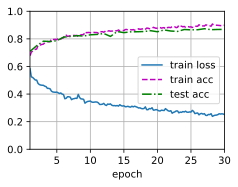

In [10]:
import torch
from torch import nn

class AttentionClassifier(nn.Module):
    def __init__(self, hidden_size, num_labels, **kwargs):
        super(AttentionClassifier, self).__init__(**kwargs)
        self.attention = nn.Linear(hidden_size, 1)
        self.classifier = nn.Linear(hidden_size, num_labels)

    def forward(self, input_ids):
        # input_ids shape: [batch_size, seq_len, hidden_size]
        attention_weights = self.attention(input_ids).squeeze(-1)
        attention_weights = nn.functional.softmax(attention_weights, dim=-1).unsqueeze(-1)
        # attention_weights shape: [batch_size, seq_len, 1]
        attention_output = input_ids * attention_weights
        # attention_output shape: [batch_size, seq_len, hidden_size]
        sum_embeddings = torch.sum(attention_output, dim=1)
        # sum_embeddings shape: [batch_size, hidden_size]
        logits = self.classifier(sum_embeddings)
        # logits shape: [batch_size, num_labels]
        return logits

net = AttentionClassifier(hidden_size=768, num_labels=2)
devices = try_all_gpus()
lr, num_epochs = 0.001, 30
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
train(net, train_loader, test_loader, loss, trainer, num_epochs, devices)